<a href="https://colab.research.google.com/github/AbhishekSinghKushwah7/Plant-Disease-Identification-via-Deep-Learning/blob/main/rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 2**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
def create_directories(output_dir, splits, classes):
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

def list_all_images(source_dir, classes):
    all_images = []
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
        all_images.extend([(img, cls) for img in images])
    return all_images

def split_dataset(all_images):
    train_val_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    return train_images, val_images, test_images

def copy_images(images, output_dir, split):
    for img_path, cls in images:
        dest_dir = os.path.join(output_dir, split, cls)
        shutil.copy(img_path, dest_dir)

def prepare_data(source_dir, output_dir, classes):
    splits = ['train', 'validation', 'test']
    create_directories(output_dir, splits, classes)
    all_images = list_all_images(source_dir, classes)
    train_images, val_images, test_images = split_dataset(all_images)
    copy_images(train_images, output_dir, 'train')
    copy_images(val_images, output_dir, 'validation')
    copy_images(test_images, output_dir, 'test')
    return len(train_images), len(val_images), len(test_images)

def build_rcnn_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_history(history, test_accuracy=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    if test_accuracy is not None:
        axes[0].axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy')
    axes[0].legend()

    # Plot Loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
source_dir = "/content/drive/MyDrive/Colab Notebooks/thermal images UL"
output_dir = "/content/drive/MyDrive/Colab Notebooks/thermal images UL"
classes = ['healthy', 'Blast', 'BLB', 'hispa', 'leaf folder', 'leaf spot']

In [ ]:
# Prepare data
train_count, val_count, test_count = prepare_data(source_dir, output_dir, classes)
print(f"Training set: {train_count} images")
print(f"Validation set: {val_count} images")
print(f"Test set: {test_count} images")


Training set: 381 images
Validation set: 127 images
Test set: 128 images


In [ ]:
# Step 1: Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 540 images belonging to 8 classes.
Found 227 images belonging to 8 classes.
Found 232 images belonging to 8 classes.


In [ ]:
# Step 2: Build the R-CNN Model
model = build_rcnn_model(input_shape=(224, 224, 3), num_classes=train_generator.num_classes)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step 3: Training the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


17/17 ━━━━━━━━━━━━━━━━━━━━ 482s 29s/step - accuracy: 0.2245 - loss: 4.7817 - val_accuracy: 0.3524 - val_loss: 1.9026
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 464s 28s/step - accuracy: 0.2601 - loss: 2.0579 - val_accuracy: 0.3744 - val_loss: 1.6338
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 492s 27s/step - accuracy: 0.3231 - loss: 1.6526 - val_accuracy: 0.3216 - val_loss: 1.5476
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 464s 28s/step - accuracy: 0.3719 - loss: 1.6248 - val_accuracy: 0.3789 - val_loss: 1.4660
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 450s 27s/step - accuracy: 0.3958 - loss: 1.4997 - val_accuracy: 0.4009 - val_loss: 1.4306
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 450s 27s/step - accuracy: 0.4403 - loss: 1.4546 - val_accuracy: 0.4405 - val_loss: 1.3806
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 506s 27s/step - accuracy: 0.3671 - loss: 1.4137 - val_accuracy: 0.4890 - val_loss: 1.2803
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 454s 27s/step - accuracy: 0.4218 - loss: 1.4185 - val_accuracy: 0.4405 - val_

In [ ]:
# Step 4: Evaluate the Model
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

# Test Accuracy
test_accuracy = None
if test_generator:
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.46296295523643494
Validation Accuracy: 0.541850209236145
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 17s/step - accuracy: 0.5566 - loss: 1.2251
Testing Accuracy: 0.5517241358757019


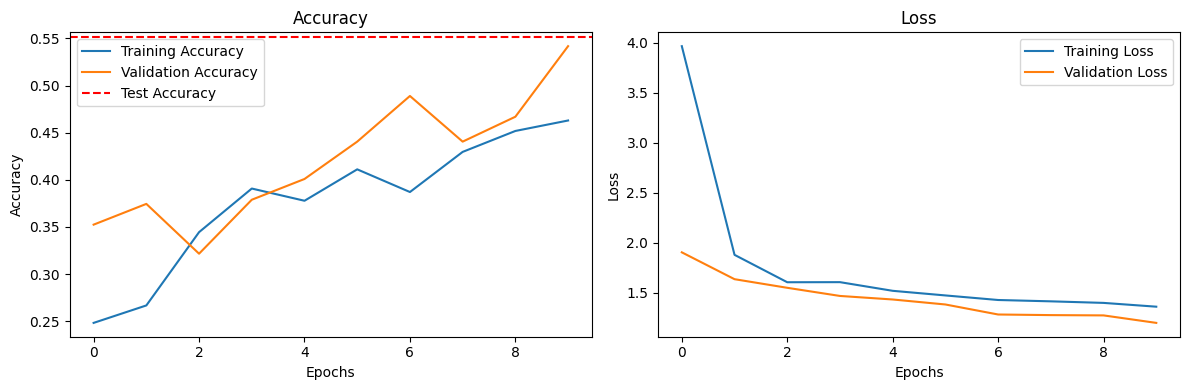

In [ ]:
# Step 5: Plot Training/Validation Accuracy and Loss
plot_history(history, test_accuracy=test_accuracy)

In [ ]:
# Step 6: Save the Model
model.save('image_classification_rcnn_model.h5')
print("Model saved as 'image_classification_rcnn_model.h5'")

Model saved as 'image_classification_rcnn_model.h5'
